In [1]:
from matplotlib import pyplot as plt

import xarray as xr
import netCDF4 as nc
import numpy as np

import os

import datetime as dt
import pickle

from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV, Ridge, LinearRegression, Lasso, ElasticNet
from sklearn.cross_decomposition import PLSRegression
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import r2_score
import random
from tqdm import tqdm
from collections import Counter
from AnchorOptimalProjector import *
from MVA_algo import ReducedRankRegressor, OPLS, OPLS2
import scipy
import h5py

In [2]:
models = ['CanESM5', 'MIROC-ES2L', 'MPI-ESM1-2-LR', 'MIROC6', 'CESM2']

In [3]:
def load_model_data(model, var, path='../data/', pkl=True):
    if not pkl :
        # Loading data file
        file_path = os.path.join(path, '{}_{}.nc'.format(model, var))
        ds = xr.open_dataset(file_path)
        # Getting TAS
        tas_array = ds[var].values
        # Close the dataset
        ds.close()
    else :
         # Loading data file
        file_path = os.path.join(path, '{}_{}.h5'.format(model, var))
        hf = h5py.File(file_path, 'r')
        tas_array = np.array(hf["data"][:]) #
        hf.close()
    return tas_array

def get_data_shape_lat_lon(model='CanESM5', var='pr', path='../data/'):
    file_path = os.path.join(path, '{}_{}.nc'.format(model, var))
    ds = xr.open_dataset(file_path)
    # Getting TAS
    shape = ds[var].values.shape
    # Close the dataset
    ds.close()
    return shape, ds['lat'], ds['lon']

def load_data_models(models, var='pr', n_sample=10, path='../data/', coarse=12, window_size=10, pkl=False):
    X, y = None, None
    for model in models:
        tas_array = load_model_data(model, var=var, path=path, pkl=pkl)
        
        shape = tas_array.shape
        
        idxs = random.sample(range(shape[0]*shape[1]), n_sample)
        tas_regional = tas_array.reshape(shape[0], shape[1], shape[2]//coarse, coarse, shape[3]//coarse, coarse)
        X_temp = tas_regional.mean(axis=(3, 5))
        rmt = X_temp.mean(axis=0)
        # Calculate regional internal variability
        riv = rmt - X_temp
        # Create a 1D convolution kernel for the moving average
        kernel = np.ones(window_size) / window_size
        # Smooth the regional internal variability using a moving average
        A_temp = np.apply_along_axis(lambda x: np.convolve(x, kernel, mode='same'), axis=1, arr=riv)
            
            
        X_temp = X_temp.reshape(shape[0]*shape[1], shape[2]*shape[3]//(coarse**2))
        y_temp = np.tile(tas_array.mean(axis=0), (shape[0], 1, 1)).reshape(shape[0]*shape[1], shape[2]*shape[3])
        A_temp = A_temp.reshape(shape[0]*shape[1], shape[2]*shape[3]//(coarse**2))

        if X is None:
            X = X_temp[idxs,:]
            y = y_temp[idxs,:]
            A = A_temp[idxs, :] 
        else :
            X = np.vstack((X, X_temp[idxs,:]))
            y = np.vstack((y, y_temp[idxs,:]))
            A = np.vstack((A, A_temp[idxs,:]))
        del tas_array
        del X_temp
        del y_temp
        del A_temp
    return A, X, y

In [4]:
shape, lat, lon = get_data_shape_lat_lon()
d = shape[2]*shape[3]

In [5]:
models_train =  ['CanESM5','MPI-ESM1-2-LR', 'CESM2']
models_test =  ['MIROC-ES2L',  'MIROC6']

In [6]:
B = 15
models_test = random.choices(models, k=B)
models_train = [[model for model in models if model != model_test ] for model_test in models_test ]

In [7]:
occurence_models_test = Counter(models_test)
occurence_models_test

Counter({'CESM2': 4,
         'MIROC6': 2,
         'MIROC-ES2L': 1,
         'CanESM5': 2,
         'MPI-ESM1-2-LR': 3})

In [8]:
N = 1500
n_components = np.arange(1, 102, 5)
regularisations = [10, 100, 1000]
coarse = 6
gammas = [2, 5, 10]

In [9]:
try :
    directory = '../weights/'
    file = 'Anchor_OPLS_precip_weights_stability_n{}_coarse{}.pkl'.format(N, coarse)
    with open(directory + file, 'rb') as f:
        weights = pickle.load(f)
except:
    print('Weights does not exists!')
    weights = {model:{gamma : {'weights':None, 'n_samples': N*occurence_models_test[model]} for gamma in gammas} for model in models}
    
for model in models : 
    for gamma in gammas :
        if gamma not in weights[model].keys():
            weights[model][gamma]['weights'] = None
            weights[model][gamma]['n_samples'] = N*occurence_models_test[model]

In [19]:
weights

{'CanESM5': {2: {'weights': None, 'n_samples': 1500},
  5: {'weights': None, 'n_samples': 1500},
  10: {'weights': None, 'n_samples': 1500}},
 'MIROC-ES2L': {2: {'weights': None, 'n_samples': 4500},
  5: {'weights': None, 'n_samples': 4500},
  10: {'weights': None, 'n_samples': 4500}},
 'MPI-ESM1-2-LR': {2: {'weights': None, 'n_samples': 7500},
  5: {'weights': None, 'n_samples': 7500},
  10: {'weights': None, 'n_samples': 7500}},
 'MIROC6': {2: {'weights': None, 'n_samples': 0},
  5: {'weights': None, 'n_samples': 0},
  10: {'weights': None, 'n_samples': 0}},
 'CESM2': {2: {'weights': None, 'n_samples': 4500},
  5: {'weights': None, 'n_samples': 4500},
  10: {'weights': None, 'n_samples': 4500}}}

In [20]:
for i in tqdm(range(len(models_test))):
    m_train, m_test = models_train[i], models_test[i]
    #print('Fitting optimal ridge {}/{}'.format(i, B))
    #print("Extracting data...", end='\r')
    # print("Loading data...")
    A_train, X_train, Y_train = load_data_models(m_train, n_sample=N, coarse=coarse)
    # print("Data loaded!")
    #print("Data extracted!")
    
    # print("Transforming data...")
    # print('Transform training data with AOP...')
    AOP = AnchorOptimalProjection(gamma=gammas)
    X_trains, Y_trains = AOP.fit_transform(A_train, X_train, Y_train)
    del A_train
    del X_train
    del Y_train
    # print('Data transformed!')
    # print("Data transformed!")
    
    for gamma in gammas:
        # print("Training anchor RRR (gamma={:.1f})...".format(gamma))
        score, ncp_opt, reg_opt = -np.Inf, None, None
        X_train, X_val, Y_train, Y_val = train_test_split(X_trains[gamma], Y_trains[gamma])
        
        # print("computing covariances")
        C_XY = X_train.T @ Y_train 
        C_XX = X_train.T @ X_train
        
        del X_train
        del Y_train
        
        # Trick for C_XX inversion
        
        for reg in regularisations:
            # print("Inverting C_XX")
            C_XX_inv = np.linalg.inv(C_XX + reg * np.identity(C_XX.shape[0]))
            # print('Computing EVD')
            C = C_XY.T @ C_XX_inv @ C_XY
            # print(C.shape)
            u, v = scipy.sparse.linalg.eigs(C, k=np.max(n_components))
            u, v = u.real, v.real
            idx = np.argsort(u)[::-1]
            eig = u[idx]
            V = v[:, idx]
            # print("Computing U")
            U = C_XX_inv @ C_XY @ V
                
            for n_cp in n_components[::-1]:
                # training reduce rank regression
                Y_pred = X_val @ U[:,:n_cp] @ V.T[:n_cp, :]
                score_temp = r2_score(Y_val, Y_pred)
                if score_temp>score:
                    score = score_temp
                    ncp_opt = n_cp
                    reg_opt = reg
                # print(gamma, reg, n_cp, score_temp)
        del X_val
        del Y_val
            
        print(score, ncp_opt, reg_opt, gamma)
        # print('Selected alpha : {} - Selected rank {} - with score {:.3f}'.format(alpha_opt, rank_opt, score))
        # print("A-RRRR regression fitted!")
        # print('Saving weights...', end='\r')
        if weights[m_test][gamma]['weights'] is None:
            weights[m_test][gamma]['weights'] = U[:,:ncp_opt] @ V.T[:ncp_opt, :]
        else:
            weights[m_test][gamma]['weights'] = (weights[m_test][gamma]['n_samples']*weights[m_test][gamma]['weights'] + N*occurence_models_test[m_test]*U[:,:ncp_opt] @ V.T[:ncp_opt, :])/(N*occurence_models_test[m_test] + weights[m_test][gamma]['n_samples'])
            weights[m_test][gamma]['n_samples'] += N*occurence_models_test[m_test]
        # print("Weights saved!")
# Save the weights for this alpha to a file
file_path = f'../weights/Anchor_OPLS_precip_weights_stability_n{N}_coarse{coarse}.pkl'
with open(file_path, 'wb') as f:
    pickle.dump(weights, f)

  0%|          | 0/12 [00:00<?, ?it/s]

0.03444210841227495 11 100 2
0.04898062840563623 101 1000 5


  8%|▊         | 1/12 [07:50<1:26:14, 470.45s/it]

0.09732243271127601 101 100 10
0.034121166983630026 11 100 2
0.05205989981871439 101 100 5


 17%|█▋        | 2/12 [15:31<1:17:26, 464.66s/it]

0.10546625781975079 101 100 10
0.03479616737297873 16 100 2
0.052675775602680955 101 100 5


 25%|██▌       | 3/12 [23:11<1:09:23, 462.65s/it]

0.10563418514428093 101 100 10
0.03417241445600585 11 100 2
0.05318861959450403 101 1000 5


 33%|███▎      | 4/12 [31:14<1:02:44, 470.62s/it]

0.10306346237748774 101 100 10
0.0388622643432255 16 100 2
0.05592987165627267 101 100 5


 42%|████▏     | 5/12 [39:01<54:46, 469.49s/it]  

0.10792401732085558 101 100 10
0.022223917354897996 101 1000 2
0.03984710608098108 101 1000 5


 50%|█████     | 6/12 [47:00<47:15, 472.63s/it]

0.09125584185141544 101 100 10
0.03462077832821521 16 100 2
0.051209833559909664 101 1000 5


 58%|█████▊    | 7/12 [54:34<38:53, 466.72s/it]

0.10155380880005384 101 100 10
0.041350159300450884 11 100 2
0.05373267524584024 101 1000 5


 67%|██████▋   | 8/12 [1:01:50<30:27, 456.83s/it]

0.10160394022637972 101 100 10
0.03424139069571394 16 100 2
0.06026528667461281 101 100 5


 75%|███████▌  | 9/12 [1:09:00<22:25, 448.42s/it]

0.1016823776184788 101 100 10
0.03425864284519045 11 100 2
0.04950621386863506 101 1000 5


 83%|████████▎ | 10/12 [1:16:29<14:57, 448.53s/it]

0.1054137437899958 101 10 10
0.034926543287630264 16 100 2
0.05803089049239974 101 100 5


 92%|█████████▏| 11/12 [1:23:59<07:29, 449.02s/it]

0.10244978328943367 101 100 10
0.03321893360475274 21 100 2
0.05392210251731264 101 100 5


100%|██████████| 12/12 [1:31:37<00:00, 458.12s/it]

0.09998153179701882 101 100 10


In [10]:
directory = '../weights/'
file = 'Anchor_OPLS_precip_weights_stability_n{}_coarse{}.pkl'.format(N, coarse)
with open(directory + file, 'rb') as f:
    weights = pickle.load(f)

In [14]:
R = 6
scores_pattern = {model:{gamma:[] for gamma in weights[model].keys()} for model in models}
for b in tqdm(range(R)):
    for model in models:
        for gamma in weights[model].keys():
            # print("Extracting data...", end='\r')
            _, X_test, Y_test = load_data_models([model], var='pr', coarse=coarse, n_sample=1000)
            # print('Data extracted!')
            # print("Predicting data ...", end='\r')
            # print("Loading weights")
            W = weights[model][gamma]['weights']
            print(model)
            print(W.shape)
            print(X_test.shape)
            print()
            # print("Prediction")
            Y_pred = Y_pred = X_test @ W
            # print("Data predicted")
            # print("Computing scores for ({} - {})".format(model, gamma), end='\r')
            # print("Computing scores")
            score_pattern = r2_score(Y_test, Y_pred, multioutput='raw_values')
            scores_pattern[model][gamma].append(score_pattern)
            del X_test
            del Y_pred
            del Y_test
            # print("Score computed!")


  0%|          | 0/6 [00:00<?, ?it/s]

CanESM5
(288, 10368)
(1000, 288)

CanESM5
(288, 10368)
(1000, 288)

CanESM5
(288, 10368)
(1000, 288)

MIROC-ES2L
(288, 10368)
(1000, 288)

MIROC-ES2L
(288, 10368)
(1000, 288)



In [ ]:
gamma=1

In [ ]:
np.array([np.mean(scores_pattern[model][gamma], axis=1) for model in models]).mean()

0.02052562789825153

0.4077868904642828

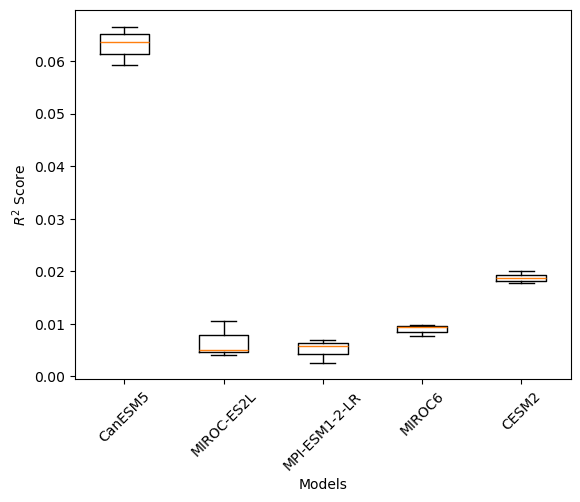

In [ ]:
plt.boxplot([np.mean(scores_pattern[model][gamma], axis=1) for model in models])
# Boxplot
# Set xticklabels with alpha values
plt.xticks(range(1, len(models) + 1), [model for model in models], rotation=45)

# Set xlabel with alphas
plt.xlabel(r'Models')

# Set ylabel with r2 score
plt.ylabel(r'$R^2$ Score')

directory = '../Results'
plt.savefig(directory + "/R2_pr_anchor_OPLS{}_stability_coarse{}_precip.pdf".format(gamma, coarse), format="pdf", bbox_inches="tight")

plt.show()

In [ ]:
model = 'CanESM5'
scores_pattern_maps = np.mean(scores_pattern[model][gamma], axis=0).reshape(len(lat), len(lon))

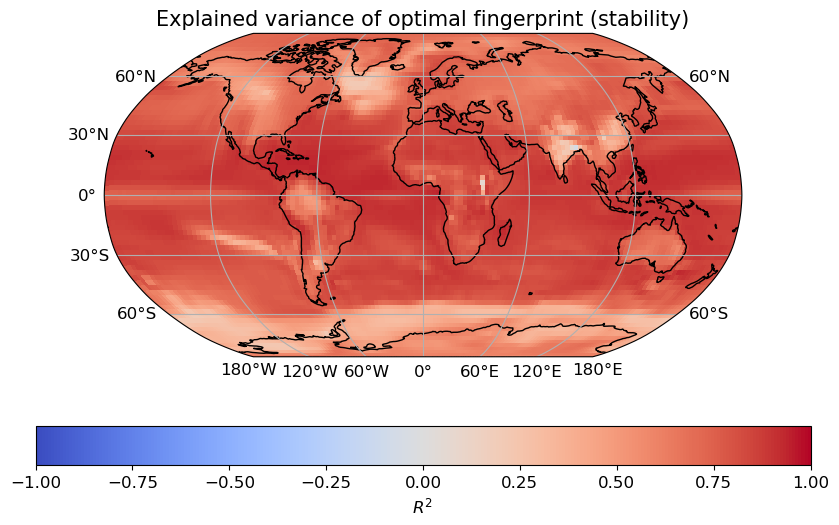

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from matplotlib.colors import TwoSlopeNorm

# Assuming you have defined lat, lon, diff_r2_map, diff_corr_map, max_val_r2, max_val_corr

# Plotting
fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.Robinson())

# Plot for diff_r2_map
norm_r2 = TwoSlopeNorm(vmin=-1.0, vcenter=0.0, vmax=1)
contour_r2 = ax.pcolormesh(lon, lat, scores_pattern_maps, transform=ccrs.PlateCarree(), cmap='coolwarm', norm=norm_r2)
ax.coastlines()

gl = ax.gridlines(draw_labels=True)
gl.top_labels = gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 12}  # Longitude font size
gl.ylabel_style = {'size': 12}  # Latitude font size

ax.set_title(r'Explained variance of optimal fingerprint (stability)', fontsize=15)

cb = plt.colorbar(contour_r2, ax=ax, label='R2 score differences', orientation='horizontal')
cb.ax.tick_params(labelsize=12)
cb.set_label(r'$R^2$ ', fontsize=12) 

directory = '../Results'
plt.savefig(directory + "/maps_R2_anchor{}_stability_coarse_{}_{}_precip.pdf".format(gamma, coarse, model), format="pdf", bbox_inches="tight")


plt.show()